Data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
dir_data = "/content/gdrive/My Drive/Colab Notebooks/SML/dataset1"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

import glob, os
all_img_paths = glob.glob(os.path.join(dir_img, "*.png"))
all_mask_paths = glob.glob(os.path.join(dir_seg, "*.png"))

In [3]:
import cv2
import imageio

x = []
y = []
for i in range(len(all_img_paths)):
    img = cv2.imread(all_img_paths[i])
    img = cv2.resize(img, (224,224))
    mask_path = dir_seg + all_img_paths[i].split('/')[-1]
    img_mask = cv2.imread(mask_path)
    img_mask = cv2.resize(img_mask, (224,224))
    x.append(img)
    y.append(img_mask)

Data 특징

In [5]:
import numpy as np
print(np.array(y).shape)
print(np.array(x).shape)

(367, 224, 224, 3)
(367, 224, 224, 3)


(array([51186.,   945., 47910.,  6099.,   282.,   633.,   528.,  2331.,
          699., 39915.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

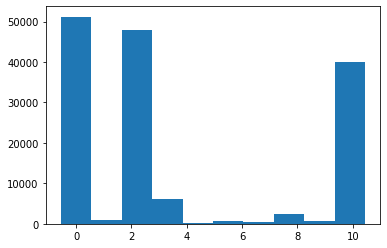

In [6]:
import matplotlib.pyplot as plt
x=np.array(x)
y=np.array(y)
plt.hist(y[2].flatten(), align='left')

In [ ]:
y1=np.where(y==8, 1.0, 0.0)
print(np.array(y1).shape)

(367, 224, 224, 3)


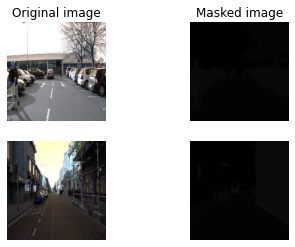

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(221)
plt.imshow(x[1])
plt.axis("off")
plt.title("Original image")
plt.grid("off")

plt.subplot(222)
plt.imshow(y[1])
plt.axis("off")
plt.title("Masked image")
plt.grid("off")

plt.subplot(223)
plt.imshow(x[2])
plt.axis("off")
plt.grid("off")

plt.subplot(224)
plt.imshow(y[2])
plt.axis("off")
plt.grid("off")
plt.show()

In [ ]:
x = np.array(x)
y2 = np.array(y1)[:,:,:,0]
y2 = y2.reshape(y2.shape[0], y2.shape[1], y2.shape[2], 1)
print(x.shape, y2.shape)
x = x/255

(367, 224, 224, 3) (367, 224, 224, 1)


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape = (224,224,3), include_top=False, weights="imagenet") # 학습된 모수 이용
base_vgg16.trainable = False
base_vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [11]:
conv1 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block5_conv3').output).output
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
merge6 = concatenate([drop4, up6], axis=-1) # residual connection(잔차연결)

conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
merge7 = concatenate([conv3, up7], axis=-1)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
merge8 = concatenate([conv2, up8], axis=-1)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
merge9 = concatenate([conv1, up9], axis=-1)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(12, 1, activation='sigmoid')(conv9)

In [12]:
model = Model(inputs=base_vgg16.input, outputs=conv10)
for layer in model.layers[:18]:
    layer.trainable = False # 모수 고정

In [13]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [15]:
model.compile(optimizer=Adam(1e-3, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy']) #class : 12개의 channel
history = model.fit(x, y, epochs=10, batch_size=1, validation_split=0.1)

Epoch 1/10


ValueError: ignored

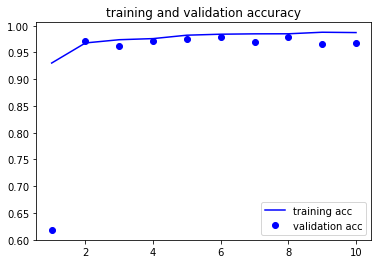

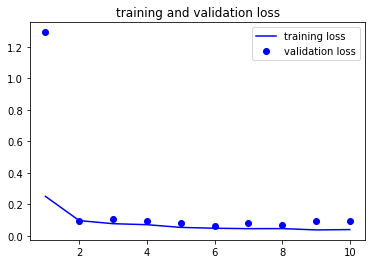

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='training acc')
plt.plot(epochs, val_acc, 'bo', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'bo', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred, axis=-1)
y_testi = np.argmax(y2[-2:], axis=-1)
np.mean(y_predi == y_testi)

1.0

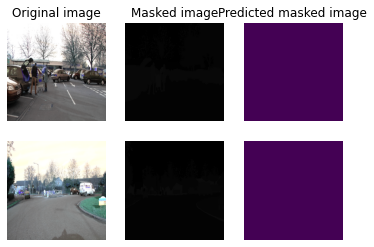

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(231)
plt.imshow(x[-1])
plt.axis("off")
plt.title("Original image")
plt.grid("off")

plt.subplot(232)
plt.imshow(y[-1])
plt.axis("off")
plt.title("Masked image")
plt.grid("off")

plt.subplot(233)
plt.imshow(y_predi[-1])
plt.axis("off")
plt.title("Predicted masked image")
plt.grid("off")

plt.subplot(234)
plt.imshow(x[-2])
plt.axis("off")
plt.grid("off")

plt.subplot(235)
plt.imshow(y[-2])
plt.axis("off")
plt.grid("off")

plt.subplot(236)
plt.imshow(y_predi[-2])
plt.axis("off")
plt.grid("off")
plt.show()